<p align="center">
  <a href="url"><img src="https://images.unsplash.com/photo-1507720708252-1ddeb1dbff34?ixlib=rb-1.2.1&auto=format&fit=crop&w=1668&q=80" align="middle" height="383" width="640" ></a>
</p>

# Bagaimana Membuat Fully-Connected Image Classifier


Di dalam tutorial, kamu akan melatih sebuah fully-connected neural network untuk melakukan image classification bunga dandelion dan rumput. KIta akan menggunakan Framework Deep Learning TensorFlow untuk membuat neural network dan training/validation dataset. Pertama, silahkan download training and validation data.


### Building the Image Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import zipfile

local_zip = '/content/drive/MyDrive/train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./tmp')

local_zip = '/content/drive/MyDrive/valid.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./tmp')
zip_ref.close()

In [ ]:
os.getcwd()

'/content'

In [ ]:
# Directory with our training dandelion pictures
train_dandelion_dir = os.path.join('./tmp/train/dandelion')

# Directory with our training grass pictures
train_grass_dir = os.path.join('./tmp/train/grass')

# Directory with our validation dandelion pictures
valid_dandelion_dir = os.path.join('./tmp/valid/dandelion')

# Directory with our validation grass pictures
valid_grass_dir = os.path.join('./tmp/valid/grass')

In [ ]:
print(train_dandelion_dir)

./tmp/train/dandelion


In [ ]:
train_dandelion_names = os.listdir(train_dandelion_dir)
print(train_dandelion_names[:10])

train_grass_names = os.listdir(train_grass_dir)
print(train_grass_names[:10])

validation_dandelion_hames = os.listdir(valid_dandelion_dir)
print(validation_dandelion_hames[:10])

validation_grass_names = os.listdir(valid_grass_dir)
print(validation_grass_names[:10])

['00000253.jpg', '00000474.jpg', '00000454.jpg', '00000369.jpg', '00000487.jpg', '00000149.jpg', '00000228.jpg', '00000068.jpg', '00000479.jpg', '00000033.jpg']
['00000253.jpg', '00000474.jpg', '00000454.jpg', '00000369.jpg', '00000487.jpg', '00000149.jpg', '00000228.jpg', '00000068.jpg', '00000479.jpg', '00000033.jpg']
['00000068.jpg', '00000033.jpg', '00000085.jpg', '00000083.jpg', '00000027.jpg', '00000080.jpg', '00000015.jpg', '00000028.jpg', '00000007.jpg', '00000032.jpg']
['00000033.jpg', '00000027.jpg', '00000015.jpg', '00000028.jpg', '00000007.jpg', '00000032.jpg', '00000029.jpg', '00000003.jpg', '00000049.jpg', '00000026.jpg']


In [ ]:
print('total training dandelion images:', len(os.listdir(train_dandelion_dir)))
print('total training grass images:', len(os.listdir(train_grass_dir)))
print('total validation dandelion images:', len(os.listdir(valid_dandelion_dir)))
print('total validation grass images:', len(os.listdir(valid_grass_dir)))

total training dandelion images: 500
total training grass images: 499
total validation dandelion images: 92
total validation grass images: 65


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

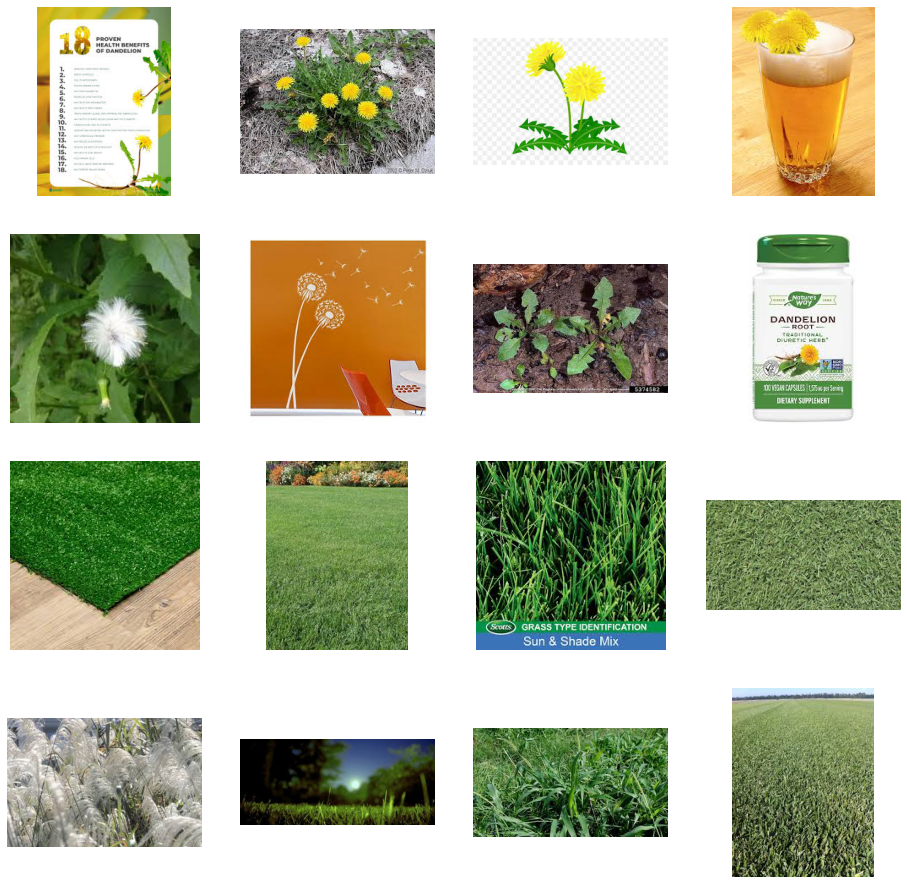

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_dandelion_pic = [os.path.join(train_dandelion_dir, fname) 
                for fname in train_dandelion_names[pic_index-8:pic_index]]
next_grass_pic = [os.path.join(train_grass_dir, fname) 
                for fname in train_grass_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_dandelion_pic + next_grass_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


#### Data Preprocessing


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 120 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        './tmp/train/',  # This is the source directory for training images
        classes = ['dandelion', 'grass'],
        target_size=(224, 224),  # All images will be resized to 200x200
        batch_size=120,
        # Use binary labels
        class_mode='binary')

# Flow validation images in batches of 19 using valid_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        './tmp/valid/',  # This is the source directory for training images
        classes = ['dandelion', 'grass'],
        target_size=(224, 224),  # All images will be resized to 200x200
        batch_size=19,
        # Use binary labels
        class_mode='binary',
        shuffle=False)

Found 999 images belonging to 2 classes.
Found 157 images belonging to 2 classes.


## Building the Model from Scratch



In [ ]:
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model summary

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 26, 26, 128)     

In [ ]:
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

### Training
15 epochs.

steps_per_epoch * batch_size = total  of images. <br>
8 * 120 = 960, < 999

In [ ]:
# history = model.fit(
#       train_generator,
#       steps_per_epoch=8,  
#       epochs=15,
#       verbose=1,
#       validation_data = validation_generator,
#       validation_steps=8)

history = model.fit(train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/15
8/8 [==============================] - 4s 455ms/step - loss: 0.2379 - accuracy: 0.9094 - val_loss: 0.3956 - val_accuracy: 0.8224
Epoch 2/15
8/8 [==============================] - 3s 364ms/step - loss: 0.1979 - accuracy: 0.9261 - val_loss: 0.3901 - val_accuracy: 0.8158
Epoch 3/15
8/8 [==============================] - 4s 495ms/step - loss: 0.1793 - accuracy: 0.9344 - val_loss: 0.5699 - val_accuracy: 0.7697
Epoch 4/15
8/8 [==============================] - 3s 355ms/step - loss: 0.1417 - accuracy: 0.9443 - val_loss: 0.4451 - val_accuracy: 0.8224
Epoch 5/15
8/8 [==============================] - 3s 383ms/step - loss: 0.1309 - accuracy: 0.9522 - val_loss: 0.5168 - val_accuracy: 0.8092
Epoch 6/15
8/8 [==============================] - 4s 560ms/step - loss: 0.1402 - accuracy: 0.9477 - val_loss: 0.4493 - val_accuracy: 0.8092
Epoch 7/15
8/8 [==============================] - 3s 401ms/step - loss: 0.1208 - accuracy: 0.9625 - val_loss: 0.5914 - val_accuracy: 0.7434
Epoch 8/15
8/8 [====

## Accuracy, ROC Curve, and AUC

In [ ]:
model.evaluate(validation_generator)

9/9 [==============================] - 0s 36ms/step - loss: 0.7188 - accuracy: 0.8025


[0.7188252210617065, 0.8025477528572083]

In [ ]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
                      verbose=1)

9/9 [==============================] - 0s 37ms/step


In [ ]:
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)

In [ ]:
roc_auc = auc(fpr, tpr)

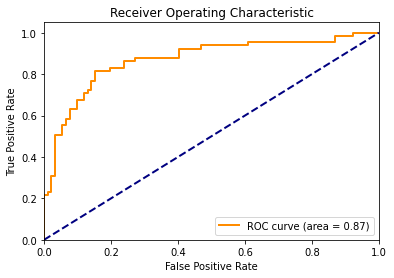

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Making Predictions

In [ ]:
# list_file = os.listdir('C:/Users/Nycht/Desktop/darurat/flower-recognition/prediction')

Saving dandelions_flower_dandelion_224308.jpg to dandelions_flower_dandelion_224308 (6).jpg
1/1 [==============================] - 0s 20ms/step
[0.]
dandelions_flower_dandelion_224308.jpg ini adalah bunga dandelion


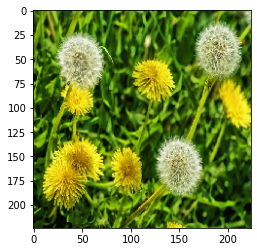

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  plt.imshow(x/255.)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]<0.5:
    print(fn + " ini adalah bunga dandelion")
  else:
    print(fn + " ini adalah rumput")
 